This notebook is for testing different embedding models on Chinese Wordnet synsets.

Usagae:
- after import relevant packages and install Chinese Wordnet data, run `functions used` chunk.
- initiate a model from sentence-transformers, and specifiy the model name in `compute_similarity_st()`
- the function will return pair-wise cosine simialrity measures for the synsets and store them in a data frame

### import packages and Chinese Wordnet data

In [1]:
from word_similarity import compute_similarity_st, generate_boxplot
import pandas as pd 
import numpy as np
import sentence_transformers
import transformers
import torch
import re
import os


# install chinese wordnet datda
! pip install cwngraph 

# import sub synset varialbe
from word_similarity.chinese_wordnet import sub_synset

Chinese wordnet synset structure

In [2]:
# Chinese wordnet synset structure
from CwnGraph import CwnImage
cwn = CwnImage.latest()

synsets = cwn.get_all_synsets()

synsets[5].relations

[('is_synset', <CwnSense[04119401](率領，nom,VF): 上級帶領下級做後述事件。>, 'reversed'),
 ('is_synset', <CwnSense[05197901](率，VF): 上級帶領下級做後述事件。>, 'reversed'),
 ('is_synset', <CwnSense[05075706](部，VF): 上級帶領下級做後述事件。>, 'reversed'),
 ('is_synset', <CwnSense[06791414](帶，VC): 上級帶領下級做後述事件。>, 'reversed'),
 ('is_synset', <CwnSense[07103403](領，VC): 上級帶領下級做後述事件。>, 'reversed'),
 ('is_synset', <CwnSense[06023202](帥，VF): 上級帶領下級做後述事件。>, 'reversed')]

### sentence transformers
- uer/sbert-chinese

In [3]:
from sentence_transformers import SentenceTransformer

# initiate model
model_2 = SentenceTransformer('uer/sbert-base-chinese-nli')

# compute
synset_sim_SbertChinese = compute_similarity_st(sub_synset, model=model_2, statistics=True)



Processing sublists: 100%|██████████| 578/578 [00:37<00:00, 15.22it/s]

count    4829.0000
mean        0.6719
std         0.1683
min        -0.0527
25%         0.5534
50%         0.6787
75%         0.8066
max         0.9950
Name: cos_sim, dtype: object


In [5]:
synset_sim_SbertChinese

,w1,w2,cos_sim
0,吸菸,吸煙,0.845383
1,吸菸,抽煙,0.761936
2,吸菸,抽菸,0.910458
3,吸煙,抽煙,0.921914
4,吸煙,抽菸,0.827638
...,...,...,...
4824,要麼,或,0.682893
4825,要麼,要不,0.793563
4826,一則,或,0.730699
4827,一則,要不,0.647262


- 'distiluse-base-multilingual-cased-v1'

In [4]:
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
distil_v1  = compute_similarity_st(sub_synset, model = model, statistics=True)

Processing sublists: 100%|██████████| 578/578 [00:18<00:00, 30.90it/s]


count    4829.0000
mean        0.6860
std         0.1641
min         0.1695
25%         0.5626
50%         0.6793
75%         0.8212
max         1.0000
Name: cos_sim, dtype: object


### result comparison
- fill in the simiilarity dataframe and model name to generate boxplot

<Figure size 3840x2880 with 0 Axes>

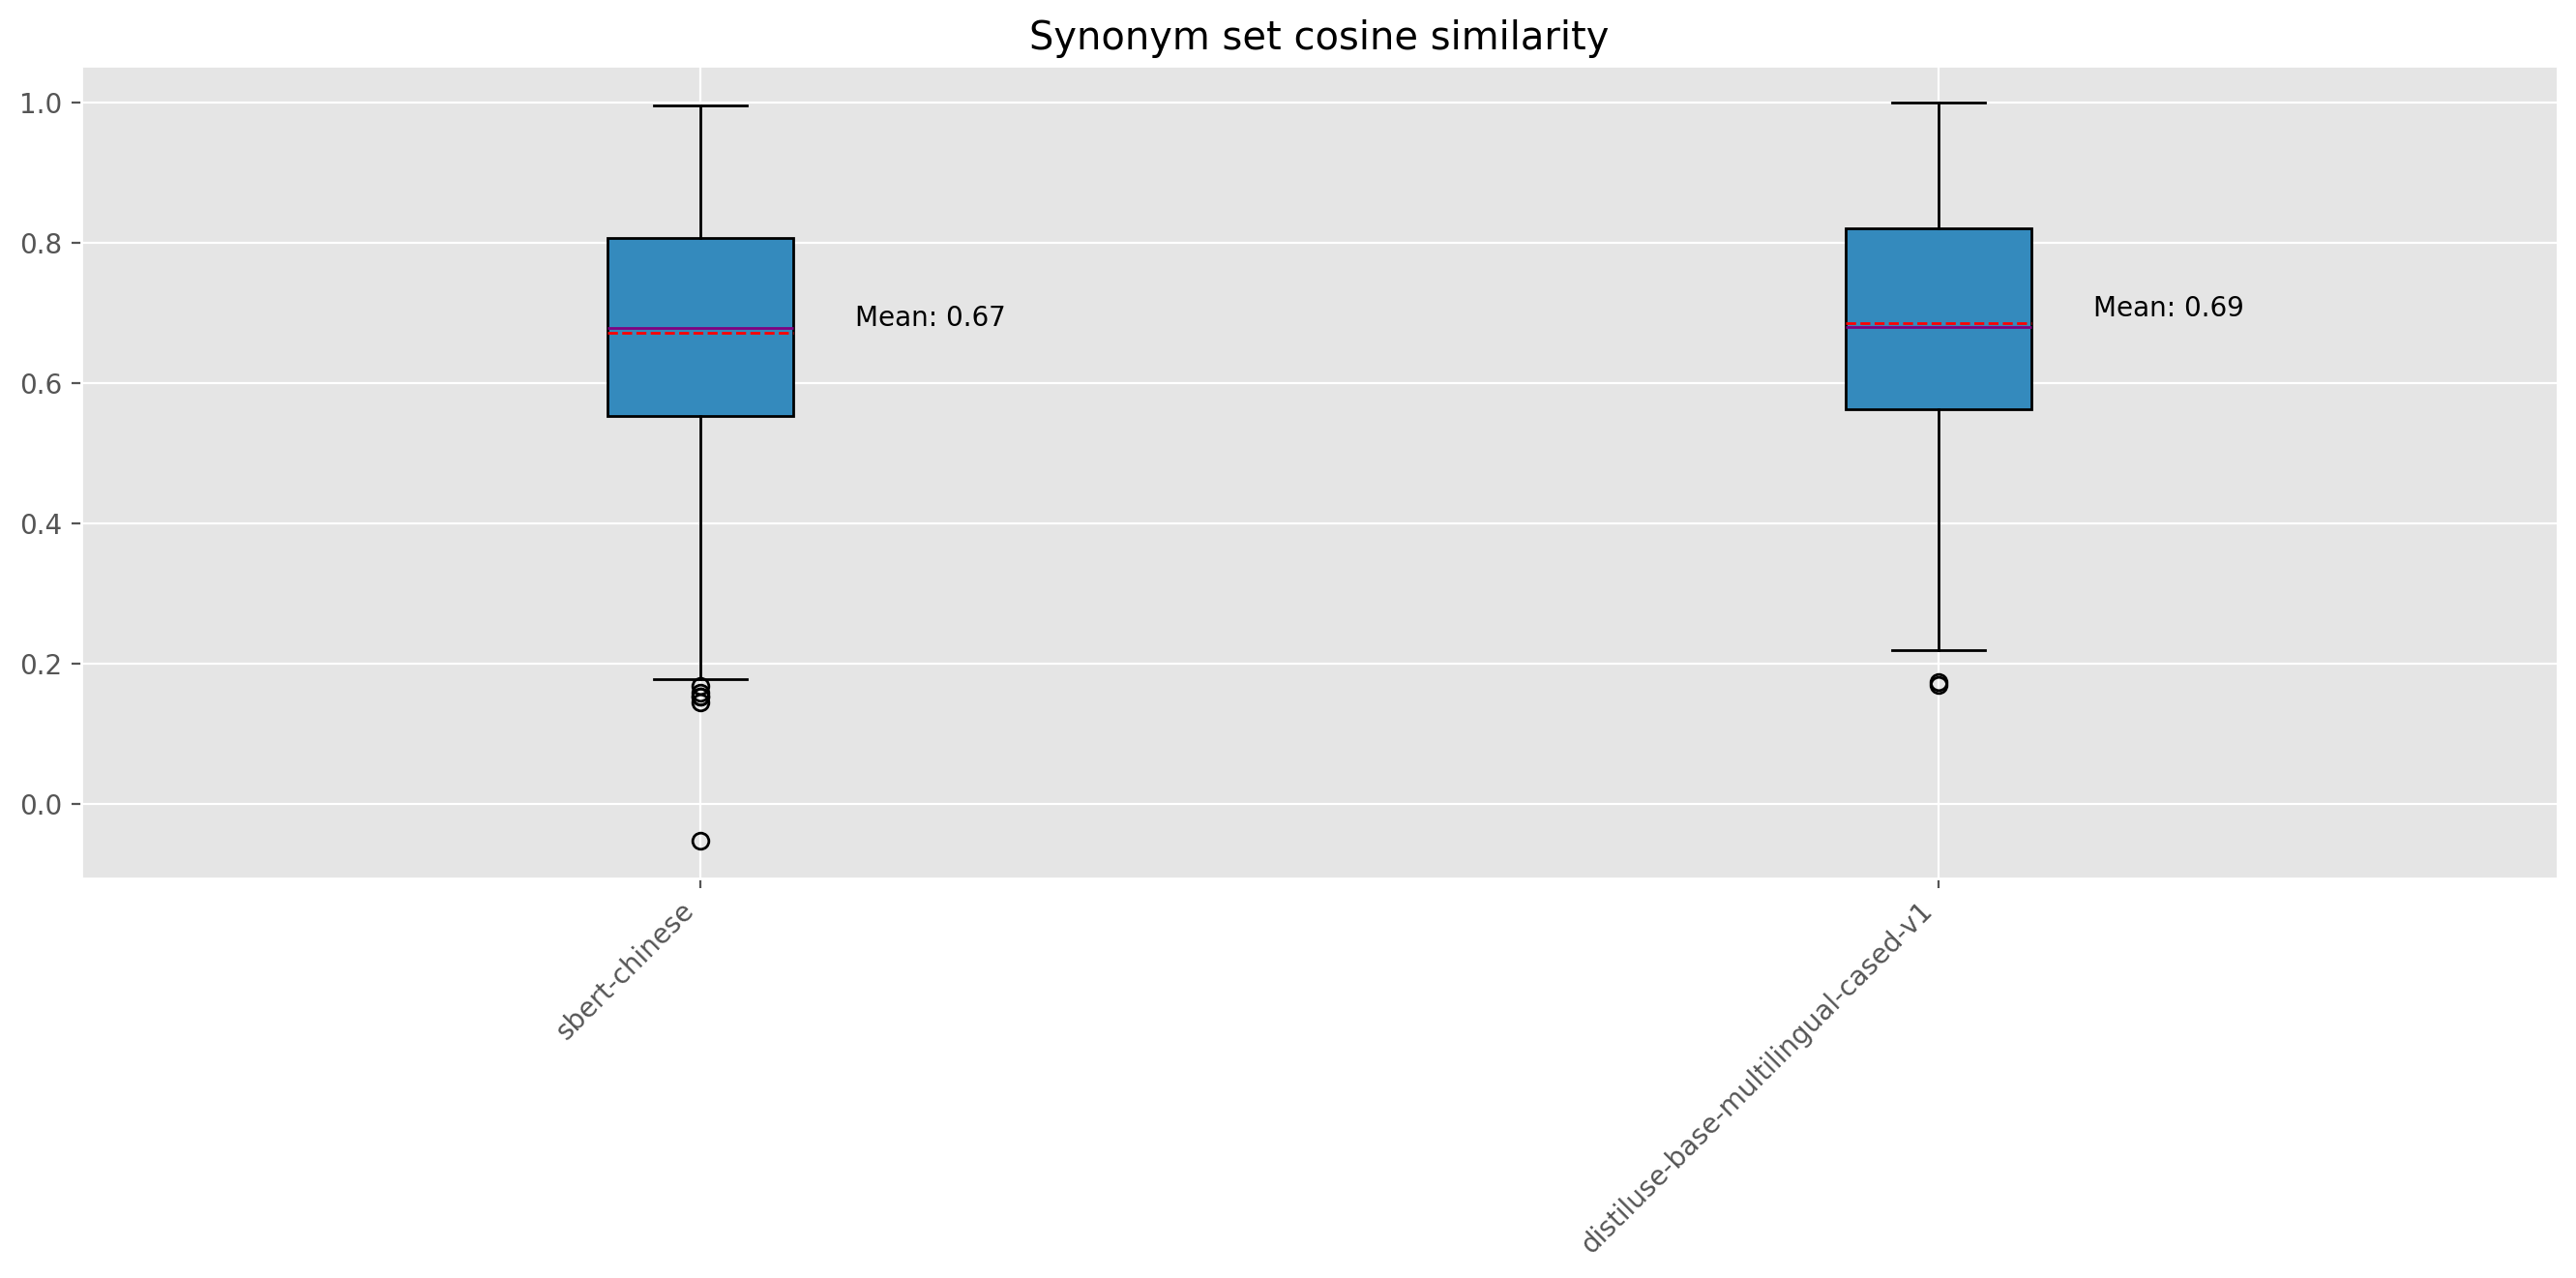

In [5]:
# generate boxplot
%config InlineBackend.figure_format = 'retina' # boost plot resolution

generate_boxplot(
    [synset_sim_SbertChinese,
     distil_v1],
     ['sbert-chinese', 
      'distiluse-base-multilingual-cased-v1']
)